In [4]:
import pandas as pd

In [1]:
import pandas as pd
import altair as alt
import polars as pl
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
bitcoin = pl.read_csv("btcusd_1-min_data.csv")

starting_date = datetime(2017, 1, 1)

bitcoin = bitcoin.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")  # Overwrite 'Timestamp'
).filter(
    pl.col("Timestamp") >= starting_date
).rename({"Timestamp": "Date"})

bitcoin

Date,Open,High,Low,Close,Volume
datetime[μs],f64,f64,f64,f64,f64
2017-01-01 00:00:00,963.16,963.16,963.16,963.16,0.0
2017-01-01 00:01:00,962.85,962.85,962.85,962.85,0.028129
2017-01-01 00:02:00,962.85,962.85,962.85,962.85,0.0
2017-01-01 00:03:00,962.85,962.85,962.85,962.85,0.0
2017-01-01 00:04:00,963.17,963.17,963.17,963.17,0.008
…,…,…,…,…,…
2024-12-15 23:56:00,104616.0,104616.0,104509.0,104520.0,0.462709
2024-12-15 23:57:00,104510.0,104510.0,104257.0,104268.0,27.923539
2024-12-15 23:58:00,104258.0,104298.0,104220.0,104298.0,1.929254


In [3]:
bitcoin

Timestamp,Open,High,Low,Close,Volume
datetime[μs],f64,f64,f64,f64,f64
2017-01-01 00:00:00,963.16,963.16,963.16,963.16,0.0
2017-01-01 00:01:00,962.85,962.85,962.85,962.85,0.028129
2017-01-01 00:02:00,962.85,962.85,962.85,962.85,0.0
2017-01-01 00:03:00,962.85,962.85,962.85,962.85,0.0
2017-01-01 00:04:00,963.17,963.17,963.17,963.17,0.008
…,…,…,…,…,…
2024-12-15 23:56:00,104616.0,104616.0,104509.0,104520.0,0.462709
2024-12-15 23:57:00,104510.0,104510.0,104257.0,104268.0,27.923539
2024-12-15 23:58:00,104258.0,104298.0,104220.0,104298.0,1.929254


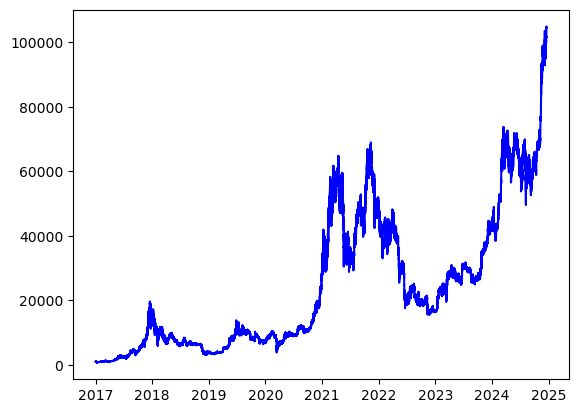

In [5]:
plt.plot(bitcoin["Date"].to_list(), bitcoin["Close"].to_list(), color="blue")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.base import BaseEstimator, RegressorMixin

class LSTMModel(nn.Module):
    def __init__(self, n_units=50, input_size=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, n_units, batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, n_units)
        out = out[:, -1, :]    # Take the last timestep's output
        if self.dropout:
            out = self.dropout(out)
        out = self.fc(out)     # (batch, 1)
        return out

class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 learning_rate=0.01,
                 n_units=50,
                 dropout=0.0,
                 loss='mse',
                 epochs=10,
                 batch_size=32,
                 verbose=0,
                 patience=3,
                 seq_len=10,
                 n_workers=0,
                 device=None):
        self.learning_rate = learning_rate
        self.n_units = n_units
        self.dropout = dropout
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.seq_len = seq_len
        self.n_workers = n_workers
        self.is_sequence_model = True

        if device is None:
            if torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)

        self.model_ = None

    def _get_loss_function(self):
        if self.loss == 'mse':
            return nn.MSELoss()
        elif self.loss == 'mae':
            return nn.L1Loss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

    def _create_sequences(self, X, y=None):
        N, _ = X.shape
        if N <= self.seq_len:
            raise ValueError("Number of observations must be greater than seq_len.")

        X_seq = []
        if y is not None:
            y_seq = []

        for i in range(N - self.seq_len):
            X_seq.append(X[i:i+self.seq_len, :])
            if y is not None:
                y_seq.append(y[i+self.seq_len])

        X_seq = np.array(X_seq, dtype=np.float32)
        if y is not None:
            y_seq = np.array(y_seq, dtype=np.float32)
            return X_seq, y_seq
        return X_seq

    def build_model(self, input_size):
        model = LSTMModel(n_units=self.n_units, input_size=input_size, dropout=self.dropout)
        return model.to(self.device)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.values.ravel()  # ensure 1D array

        X_train_seq, y_train_seq = self._create_sequences(X_train, y_train)

        # Create tensors directly on the target device
        X_train_t = torch.tensor(X_train_seq, dtype=torch.float32, device=self.device)
        y_train_t = torch.tensor(y_train_seq, dtype=torch.float32, device=self.device).unsqueeze(-1)

        _, _, input_size = X_train_seq.shape

        if self.model_ is None:
            self.model_ = self.build_model(input_size)

        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.n_workers)

        optimizer = Adam(self.model_.parameters(), lr=self.learning_rate)
        criterion = self._get_loss_function()

        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                preds = self.model_(X_batch)
                loss_val = criterion(preds, y_batch)
                loss_val.backward()
                optimizer.step()
                epoch_loss += loss_val.item() * X_batch.size(0)

            epoch_loss /= len(dataset)
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        return self

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_seq = self._create_sequences(X_test)

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, dtype=torch.float32, device=self.device)
            preds = self.model_(X_test_t)
            return preds.cpu().numpy().ravel()

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # If model parameters changed in a way that requires rebuilding the model:
        self.model_ = None
        return self

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_units': self.n_units,
            'dropout': self.dropout,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'patience': self.patience,
            'seq_len': self.seq_len,
            'device': self.device.type if isinstance(self.device, torch.device) else self.device
        }


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = ['wind_boxcox', 'load']

X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])

X_val = val[X_train.columns]
y_val = val[target]
X_test = test[X_train.columns]
y_test = test[target]

X_val[scaled_features] = scaler.transform(X_val[scaled_features])
X_test[scaled_features] = scaler.transform(X_test[scaled_features])
lstm_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "n_units": [32, 50, 100],
    "dropout": [0.0, 0.1, 0.2]
}

lstm_model = LSTMRegressor(device="cpu", batch_size=64, seq_len=21, learning_rate=0.05)

lstm_best_params = hyperparameter_tuning(
    lstm_model,
    lstm_params,
    X_train,
    y_train,
    X_val,
    y_val,
    imbalances_val,
    val["spread"]
)

results_lstm = evaluate_model(
    lstm_model, lstm_best_params[0], 
    X_train, y_train, X_val, y_val, X_test, y_test, 
    imbalances_test, test["spread"]
)

print(f"Cumulated PnL: {results_lstm['pnl_cumsum'].iloc[-1]:,.2f}€")
results_lstm['pnl_cumsum'].plot(figsize=(12, 6))